# Import Goolge Drive

In [1]:
from google.colab import drive

drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [6]:
!ls ./timit_clean/train | wc
!ls ./timit_noisy/train | wc
!ls ./serialized_train_data | wc
!ls ./serialized_test_data | wc

   4620    4620   91033
   4620    4620   91033
 103847  103847 2728687
  37953   37953  996868


In [0]:
!unzip /content/drive/My\ Drive/dataset/clean_trainset_56spk_wav -d ./ > ./unzip.log
!unzip /content/drive/My\ Drive/dataset/noisy_trainset_56spk_wav -d ./ > ./unzip.log
!unzip /content/drive/My\ Drive/dataset/clean_testset_wav -d ./ > ./unzip.log
!unzip /content/drive/My\ Drive/dataset/noisy_testset_wav -d ./ > ./unzip.log

In [0]:
!rm -rf timit_clean
!rm -rf timit_noisy
!unzip /content/drive/My\ Drive/dataset/timit_clean.zip -d ./ > ./unzip.log
!unzip /content/drive/My\ Drive/dataset/timit_noisy.zip -d ./ > ./unzip.log

In [4]:
!pip install soundfile
!pip install librosa

# Clone Github Repository

Clone

In [23]:
!rm -rf ./SEGAN
!git clone https://github.com/Peterbotliang/SEGAN.git

Cloning into 'SEGAN'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 38 (delta 18), reused 31 (delta 11), pack-reused 0
Unpacking objects: 100% (38/38), done.


# Preprocess Data

In [0]:
!mv serialized_test_data/ serialized_test_data_4096/
!mv serialized_train_data/ serialized_train_data_4096/

In [24]:
!python3 ./SEGAN/data_preprocess.py

100% 4620/4620 [01:14<00:00, 62.21it/s]
Verify serialized train audios: 100% 103847/103847 [00:56<00:00, 1826.27it/s]
100% 1680/1680 [00:26<00:00, 64.07it/s]
Verify serialized test audios: 100% 37953/37953 [00:10<00:00, 3553.79it/s]


# Tensorflow Code

## Import Module

In [1]:
import tensorflow as tf
print(tf.__version__)
print(tf.keras.__version__)
print(tf.__path__)
import numpy as np
import os
from tqdm import tqdm
from SEGAN.utils import emphasis
import tensorflow.keras.backend as K
from tensorflow.keras.utils import Sequence
import librosa
import librosa.display

1.13.1
2.2.4-tf
['/usr/local/lib/python3.6/dist-packages/tensorflow_estimator/python/estimator/api', '/usr/local/lib/python3.6/dist-packages/tensorflow', '/usr/local/lib/python3.6/dist-packages/tensorflow/_api/v1']


## SEGAN
- Generator (Autoencoder)

In [0]:
# Generator
def Conv1DTranspose(input_tensor, filters, kernel_size, strides=2, padding='same', activation=None):
    x = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=1))(input_tensor)
    x = tf.keras.layers.Conv2DTranspose(filters=filters, kernel_size=(kernel_size, 1), strides=(1, strides), padding=padding, activation=activation)(x)
    x = tf.keras.layers.Lambda(lambda x: tf.keras.backend.squeeze(x, axis=1))(x)
    return x

noisy = tf.keras.layers.Input(shape=(4096, 1))
clean = tf.keras.layers.Input(shape=(4096, 1))
z = tf.keras.layers.Input(shape=(8, 1024))
x_input = noisy
# x_enc1 = tf.keras.layers.Conv1D(filters = 16,
#                                 kernel_size = 32,
#                                 strides = 2,
#                                 padding = 'same')(x_input)
# x_enc1 = tf.keras.layers.PReLU()(x_enc1)
# x_enc2 = tf.keras.layers.Conv1D(32, 32, 2, 'same')(x_enc1)
# x_enc2 = tf.keras.layers.PReLU()(x_enc2)
x_enc3 = tf.keras.layers.Conv1D(32, 32, 2, 'same')(x_input)
x_enc3 = tf.keras.layers.PReLU()(x_enc3)
x_enc4 = tf.keras.layers.Conv1D(64, 32, 2, 'same')(x_enc3)
x_enc4 = tf.keras.layers.PReLU()(x_enc4)
x_enc5 = tf.keras.layers.Conv1D(64, 32, 2, 'same')(x_enc4)
x_enc5 = tf.keras.layers.PReLU()(x_enc5)
x_enc6 = tf.keras.layers.Conv1D(128, 32, 2, 'same')(x_enc5)
x_enc6 = tf.keras.layers.PReLU()(x_enc6)
x_enc7 = tf.keras.layers.Conv1D(128, 32, 2, 'same')(x_enc6)
x_enc7 = tf.keras.layers.PReLU()(x_enc7)
x_enc8 = tf.keras.layers.Conv1D(256, 32, 2, 'same')(x_enc7)
x_enc8 = tf.keras.layers.PReLU()(x_enc8)
x_enc9 = tf.keras.layers.Conv1D(256, 32, 2, 'same')(x_enc8)
x_enc9 = tf.keras.layers.PReLU()(x_enc9)
x_enc10 = tf.keras.layers.Conv1D(512, 32, 2, 'same')(x_enc9)
x_enc10 = tf.keras.layers.PReLU()(x_enc10)
x_enc11 = tf.keras.layers.Conv1D(1024, 32, 2, 'same')(x_enc10)
c = tf.keras.layers.PReLU()(x_enc11)

encoded = tf.keras.layers.concatenate([c, z], axis = 2)

x_dec10 = Conv1DTranspose(encoded,
                          filters = 512,
                          kernel_size = 32,
                          strides = 2,
                          padding = 'same')
x_dec10 = tf.keras.layers.PReLU()(x_dec10)
x_dec10_c = tf.keras.layers.concatenate([x_dec10, x_enc10], axis = 2)
x_dec9 = Conv1DTranspose(x_dec10_c, 256, 32, 2, 'same')
x_dec9 = tf.keras.layers.PReLU()(x_dec9)
x_dec9_c = tf.keras.layers.concatenate([x_dec9, x_enc9], axis = 2)
x_dec8 = Conv1DTranspose(x_dec9_c, 256, 32, 2, 'same')
x_dec8 = tf.keras.layers.PReLU()(x_dec8)
x_dec8_c = tf.keras.layers.concatenate([x_dec8, x_enc8], axis = 2)
x_dec7 = Conv1DTranspose(x_dec8_c, 128, 32, 2, 'same')
x_dec7 = tf.keras.layers.PReLU()(x_dec7)
x_dec7_c = tf.keras.layers.concatenate([x_dec7, x_enc7], axis = 2)
x_dec6 = Conv1DTranspose(x_dec7_c, 128, 32, 2, 'same')
x_dec6 = tf.keras.layers.PReLU()(x_dec6)
x_dec6_c = tf.keras.layers.concatenate([x_dec6, x_enc6], axis = 2)
x_dec5 = Conv1DTranspose(x_dec6_c, 64, 32, 2, 'same')
x_dec5 = tf.keras.layers.PReLU()(x_dec5)
x_dec5_c = tf.keras.layers.concatenate([x_dec5, x_enc5], axis = 2)
x_dec4 = Conv1DTranspose(x_dec5_c, 64, 32, 2, 'same')
x_dec4 = tf.keras.layers.PReLU()(x_dec4)
x_dec4_c = tf.keras.layers.concatenate([x_dec4, x_enc4], axis = 2)
x_dec3 = Conv1DTranspose(x_dec4_c, 32, 32, 2, 'same')
x_dec3 = tf.keras.layers.PReLU()(x_dec3)
x_dec3_c = tf.keras.layers.concatenate([x_dec3, x_enc3], axis = 2)
# x_dec2 = Conv1DTranspose(x_dec3_c, 32, 32, 2, 'same')
# x_dec2 = tf.keras.layers.PReLU()(x_dec2)
# x_dec2_c = tf.keras.layers.concatenate([x_dec2, 
#                                         x_enc2], axis = 2)
# x_dec1 = Conv1DTranspose(x_dec2_c, 16, 32, 2, 'same')
# x_dec1 = tf.keras.layers.PReLU()(x_dec1)
# x_dec1_c = tf.keras.layers.concatenate([x_dec1, x_enc1], axis = 2)
x_final = Conv1DTranspose(x_dec3_c, 1, 32, 2, 'same', activation='tanh')
x_final = tf.keras.layers.Add()([x_final, x_input])
G = tf.keras.models.Model(inputs = [noisy, z], outputs = [x_final])


## SRCNN

In [0]:
# def SubPixel1D(ip):
#     """One-dimensional subpixel upsampling layer
#     Calls a tensorflow function that directly implements this functionality.
#      We assume input has dim (batch, width, r)
#     """
#     X = K.permute_dimensions(ip[0], (2, 1, 0)) # (r, w, b)
#     X = tf.batch_to_space_nd(X, [ip[1]], [[0, 0]]) # (1, r*w, b)
#     X = K.permute_dimensions(X, (2, 1, 0))
#     return X

class SubPixel1D(tf.keras.layers.Layer):
    def __init__(self, r=2):
        super(SubPixel1D, self).__init__()
        self.r = r
    def call(self, I):
        """One-dimensional subpixel upsampling layer
        Calls a tensorflow function that directly implements this functionality.
         We assume input has dim (batch, width, r)
        """
#         X = K.permute_dimensions(I, (2, 1, 0)) # (r, w, b)
#         X = tf.batch_to_space_nd(X, r, [[0, 0]]) # (1, r*w, b)
#         X = K.permute_dimensions(X, (2, 1, 0))
        X = tf.transpose(I, [2,1,0]) # (r, w, b)
        X = tf.batch_to_space_nd(X, [self.r], [[0,0]]) # (1, r*w, b)
        X = tf.transpose(X, [2,1,0])
        return X

noisy = tf.keras.layers.Input(shape=(4096, 1))
clean = tf.keras.layers.Input(shape=(4096, 1))
z = tf.keras.layers.Input(shape=(8, 1024))
x_input = noisy
x = x_input

M = 9
n_filters = [128, 256, 512, 512, 512, 512, 512, 512]
kernel_sizes = [65, 33, 17, 9, 9, 9, 9, 9, 9]

# Downsampling Layers
encoder_features = []
for k, n_filter, kernel_size in zip(range(M), n_filters, kernel_sizes):
    x = tf.keras.layers.Conv1D(filters = n_filter,
                               kernel_size = kernel_size,
                               strides = 2,
                               padding = 'same')(x)
    x = tf.keras.layers.PReLU()(x)
    encoder_features.append(x)
    
# Bottleneck Layer
x = tf.keras.layers.Conv1D(filters = n_filters[-1],
                           kernel_size = kernel_sizes[-1],
                           strides = 2,
                           padding = 'same')(x)
x = tf.keras.layers.Dropout(rate=0.5)(x)
x = tf.keras.layers.PReLU()(x)

# Upsampling Layer
for k, n_filter, kernel_size, enc in reversed(list(zip(range(M), 
                                                  n_filters, 
                                                  kernel_sizes, 
                                                  encoder_features))):
    x = tf.keras.layers.Conv1D(filters = n_filter,
                               kernel_size = kernel_size,
                               strides = 1,
                               padding = 'same')(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    x = tf.keras.layers.PReLU()(x)
    x = SubPixel1D()(x)
    x = tf.keras.layers.Concatenate(axis=2)([x, enc])

# Final Conv Layer
x = tf.keras.layers.Conv1D(filters = 2,
                           kernel_size = 9,
                           strides = 1,
                           padding = 'same')(x)
x = SubPixel1D()(x)
x_final = tf.keras.layers.Add()([x, x_input])    
G = tf.keras.models.Model(inputs = [noisy, z], outputs = [x_final])    

## Train Model

Initialize Model

In [0]:
optim = tf.keras.optimizers.Adam(lr=3e-4)
def G_loss(true, fake):
    return 1 * K.sqrt(K.mean((fake - true) ** 2))

G.compile(loss = G_loss,
          optimizer = optim)
# G.summary()
# tf.keras.utils.plot_model(G, to_file='./generator.png', show_shapes=True)


Training

In [0]:
# 
def data_loader(data_path, batch_size = 32):
    filenames = [os.path.join(data_path, filename) for filename in os.listdir(data_path)]
    
    while True:
        
        noisy_batch = []
        z_batch = []
        clean_batch = []
        np.random.shuffle(filenames)
        
        for i, filename in enumerate(filenames):
            pair = np.load(filename)
            pair = emphasis(pair[np.newaxis, :, :], emph_coeff=0.95).reshape(2, -1)
            clean = pair[0].reshape(-1, 1).astype('float32')
            noisy = pair[1].reshape(-1, 1).astype('float32')
            z = np.random.randn(8, 1024).astype('float32')
    
            noisy_batch.append(noisy)
            z_batch.append(z)
            clean_batch.append(clean)
            
            if (i + 1) % batch_size == 0:
                noisy = np.array(noisy_batch)
                z = np.array(z_batch)
                clean = np.array(clean_batch)
                
                noisy_batch = []
                z_batch = []
                clean_batch = []
            
                yield (noisy, z), clean

class data_sequence(Sequence):
    def __init__(self, data_path, batch_size = 32):
        self.filenames = [os.path.join(data_path, filename) for filename in os.listdir(data_path)]
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        noisy_batch = []
        z_batch = []
        clean_batch = []
        
        for i in range(idx * self.batch_size, min(len(self.filenames), (idx + 1) * self.batch_size)):
            pair = np.load(self.filenames[i])
            pair = emphasis(pair[np.newaxis, :, :], emph_coeff=0.95).reshape(2, -1)
            clean = pair[0].reshape(-1, 1).astype('float64')
            noisy = pair[1].reshape(-1, 1).astype('float64')
            z = np.random.randn(8, 1024).astype('float64')
    
            noisy_batch.append(noisy)
            z_batch.append(z)
            clean_batch.append(clean)

        return (np.array(noisy_batch), np.array(z_batch)), np.array(clean_batch)
        
                
data_path = './serialized_train_data'
    
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/My Drive/model/weights.hdf5', verbose=1),
    tf.keras.callbacks.TensorBoard(log_dir='/content/drive/My Drive/model/logs_5', update_freq='batch')
             ]
    
G.fit_generator(data_sequence(data_path, 200), 
                steps_per_epoch = 103847 // 200, 
                verbose = 1,
                epochs = 10,
                max_queue_size = 10,
                callbacks = callbacks,
                workers = 2)


Epoch 1/10
519/520 [============================>.] - ETA: 3s - loss: 0.0041
Epoch 00001: saving model to /content/drive/My Drive/model/weights.hdf5
520/520 [==============================] - 1773s 3s/step - loss: 0.0041
Epoch 2/10
519/520 [============================>.] - ETA: 3s - loss: 0.0034
Epoch 00002: saving model to /content/drive/My Drive/model/weights.hdf5
520/520 [==============================] - 1706s 3s/step - loss: 0.0034
Epoch 3/10
252/520 [=============>................] - ETA: 14:33 - loss: 0.0032

In [33]:
%load_ext tensorboard.notebook
%tensorboard --logdir /content/drive/My\ Drive/model/logs_5

The tensorboard.notebook extension is already loaded. To reload it, use:
  %reload_ext tensorboard.notebook


Reusing TensorBoard on port 6006 (pid 5341), started 0:01:58 ago. (Use '!kill 5341' to kill it.)

In [0]:
G.load_weights('/content/drive/My Drive/model/weights.hdf5')

In [0]:
import soundfile as sf
import IPython.display as ipd
import matplotlib.pyplot as plt

window_size = 2 ** 12  # about 1 second of samples
sample_rate = 16000
stride = 0.5

def predict(file, window_size, stride, sample_rate):
    """
    Helper function for predicting the audio file
    by window size and sample rate with [1-stride] percent overlap (default 50%).
    """
    wav, sr = sf.read(file)
    hop = int(window_size * stride)
    result = np.zeros(wav.shape)
    for end_idx in range(window_size, len(wav), hop):
        start_idx = end_idx - window_size
        noisy_test = wav[start_idx:end_idx]
        noisy_test = noisy_test.reshape(1, -1, 1)
        z_test = np.random.randn(1, 8, 1024)
        clean_pred = G.predict((noisy_test, z_test), batch_size=1)
        result[start_idx: end_idx] += clean_pred.reshape(-1)
        
    s = hop
    e = end_idx - hop
    result[s:e] *= 0.5
    return result

y_pred = predict('./timit_noisy/test/DR1_FAKS0_SA2.wav', 
                     window_size, 
                     stride, 
                     sample_rate)


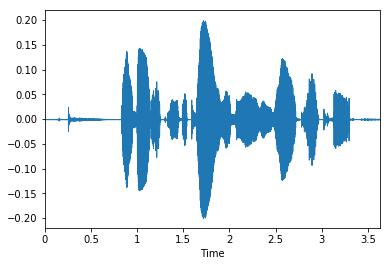

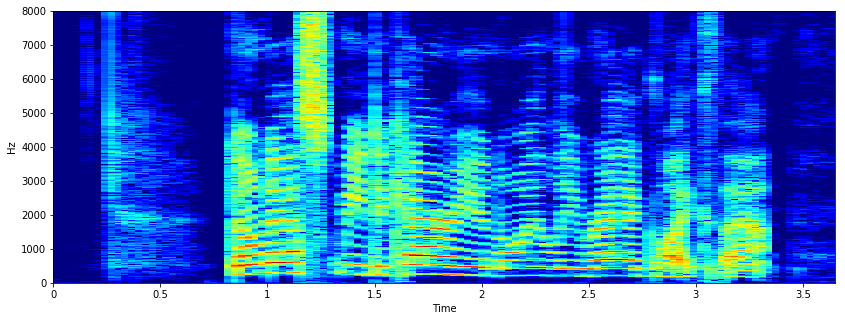

In [13]:
y_clean, fs = sf.read('./timit_clean/test/DR1_FAKS0_SA2.wav')
librosa.display.waveplot(y_clean, sr = fs)

D_clean = librosa.stft(y_clean)
D_clean_db = librosa.amplitude_to_db(abs(D_clean))
plt.figure(figsize=(14,5))
librosa.display.specshow(D_clean_db, sr=fs, x_axis='time', y_axis='hz', cmap='jet')

ipd.Audio(y_clean, rate = fs)

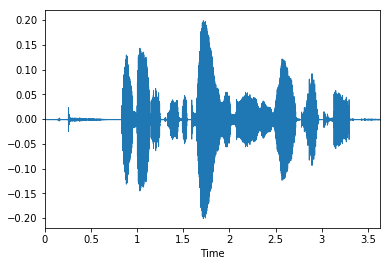

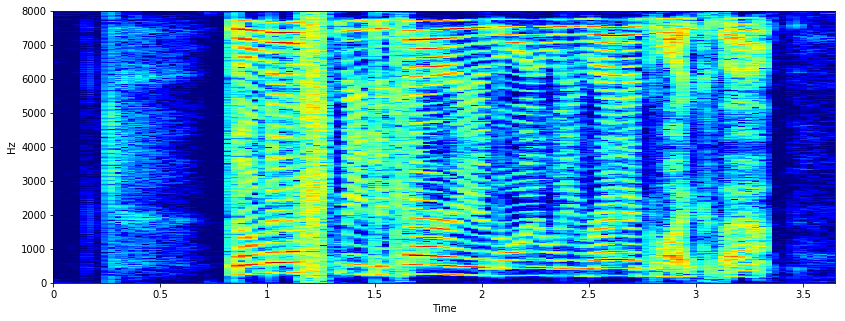

In [0]:
y_clean_fold = y_clean
y_clean_fold[::2] = 0
librosa.display.waveplot(y_clean_fold, sr = fs)

D_clean_fold = librosa.stft(y_clean_fold)
D_clean_fold_db = librosa.amplitude_to_db(abs(D_clean_fold))
plt.figure(figsize=(14,5))
librosa.display.specshow(D_clean_fold_db, sr=fs, x_axis='time', y_axis='hz', cmap='jet')

ipd.Audio(y_clean_fold, rate = fs)

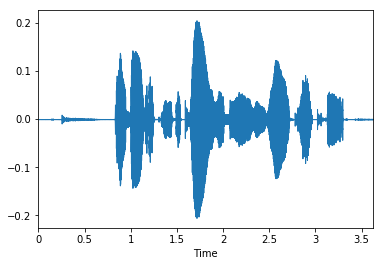

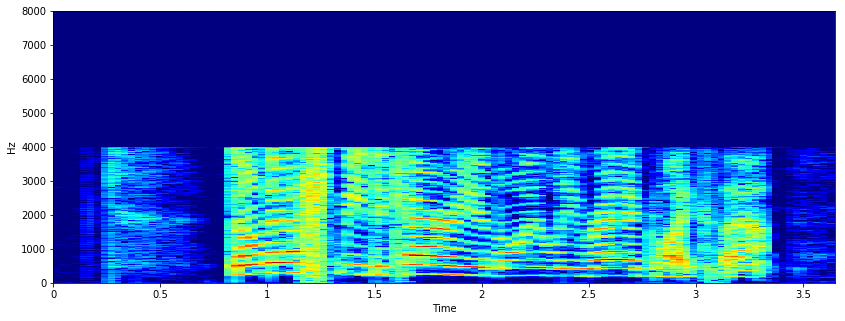

In [0]:
y_noisy, fs = sf.read('./timit_noisy/test/DR1_FAKS0_SA2.wav')
librosa.display.waveplot(y_noisy, sr = fs)

D_noisy = librosa.stft(y_noisy)
D_noisy_db = librosa.amplitude_to_db(abs(D_noisy))
plt.figure(figsize=(14,5))
librosa.display.specshow(D_noisy_db, sr=fs, x_axis='time', y_axis='hz', cmap='jet')

ipd.Audio(y_noisy, rate = fs)

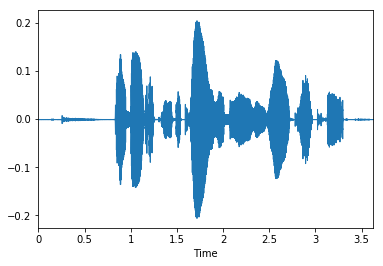

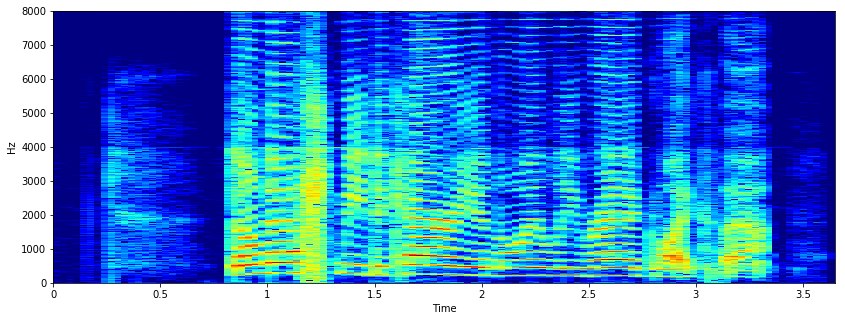

In [30]:
librosa.display.waveplot(y_pred, sr = fs)

D_pred = librosa.stft(y_pred)
D_pred_db = librosa.amplitude_to_db(abs(D_pred))
plt.figure(figsize=(14,5))
librosa.display.specshow(D_pred_db, sr=fs, x_axis='time', y_axis='hz', cmap='jet')

ipd.Audio(y_pred, rate = sample_rate)

## Dataset (test)

In [0]:

def _load_numpy(filename, emph_coff=0.95):
    pair = np.load(filename.decode())
    pair = emphasis(pair[np.newaxis, :, :], emph_coeff=0.95).reshape(2, -1)
    clean = pair[0].reshape(-1, 1).astype('float32')
    noisy = pair[1].reshape(-1, 1).astype('float32')
    z = np.random.randn(8, 1024).astype('float32')
    return clean, noisy

# dataset = tf.data.Dataset.from_tensor_slices(filenames)
# dataset = dataset.map(lambda filename : tf.py_func(_load_numpy,
#                                               [filename, 0.95],
#                                               [tf.float32, tf.float32]))

# dataset = tf.data.Dataset.from_generator(data_loader, (tf.float32, tf.float32))
# dataset = dataset.batch(32)
# iterator = dataset.make_one_shot_iterator()
# el = iterator.get_next()
# with tf.Session() as sess:
#     for i in tqdm(range(2805)):
#         pair = sess.run(el)
#         if not pair[0].shape == (32, 16384, 1):
#             print (pair[0].shape)
#         if not pair[1].shape == (32, 16384, 1):
#             print(pair[1].shape)
        # print(type(sess.run(el)), len(sess.run(el)))
        # print(type(sess.run(el)[0]), sess.run(el)[0].shape)
        # print(type(sess.run(el)[1]), sess.run(el)[1].shape)